## Data Understanding
- The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.
- The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

- Data Dictionary:
    - Input variables:
    ### bank client data:
    - 1 - age (numeric)
    - 2 - job : type of job (categorical: 'admin.','blue collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
    - 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
    - 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
    - 5 - default: has credit in default? (categorical: 'no','yes','unknown')
    - 6 - balance
    - 7 - housing: has housing loan? (categorical: 'no','yes','unknown')
    - 8 - loan: has personal loan? (categorical: 'no','yes','unknown')
    ### related with the last contact of the current campaign:
    - 9 - contact: contact communication type (categorical: 'cellular','telephone')
    - 10 - day: last contact day of the week (int: 1-7)
    - 11 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
    - 12 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
    ### other attributes:
    - 13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    - 14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    - 15 - previous: number of contacts performed before this campaign and for this client (numeric)
    - 16 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

    ### Output variable (desired target):
    - 17 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=ae70377fb4cf199bfecce64668ed520505d444a94b489cd203e5883e9314d20c
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()


In [ ]:
df = spark.read.csv('bank-full.csv', header = True, inferSchema = True)

In [ ]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



### View as a Pandas Dataframe

In [ ]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,unknown
marital,married,single,married,married,single
education,tertiary,secondary,secondary,unknown,unknown
default,no,no,no,no,no
balance,2143,29,2,1506,1
housing,yes,yes,yes,yes,no
loan,no,no,yes,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


### Is the target class balanced?

In [ ]:
df.groupby('y').count().toPandas()

,y,count
0,no,39922
1,yes,5289


- Yes, almost perfectly balanced. Dataset downloaded from Kaggle shows a nearly balanced set.

In [ ]:
#similar to printSchema, see datatypes:
df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string')]

### Show Summary Stats for numeric features

In [ ]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,45211,40.93621021432837,10.618762040975405,18,95
balance,45211,1362.2720576850766,3044.7658291685257,-8019,102127
day,45211,15.80641879188693,8.322476153044594,1,31
duration,45211,258.1630797814691,257.5278122651706,0,4918
campaign,45211,2.763840658246887,3.098020883279192,1,63
pdays,45211,40.19782796222158,100.12874599059828,-1,871
previous,45211,0.5803233726305546,2.303441044931218,0,275


### Scatter Matrix - Looking for obvious relationships

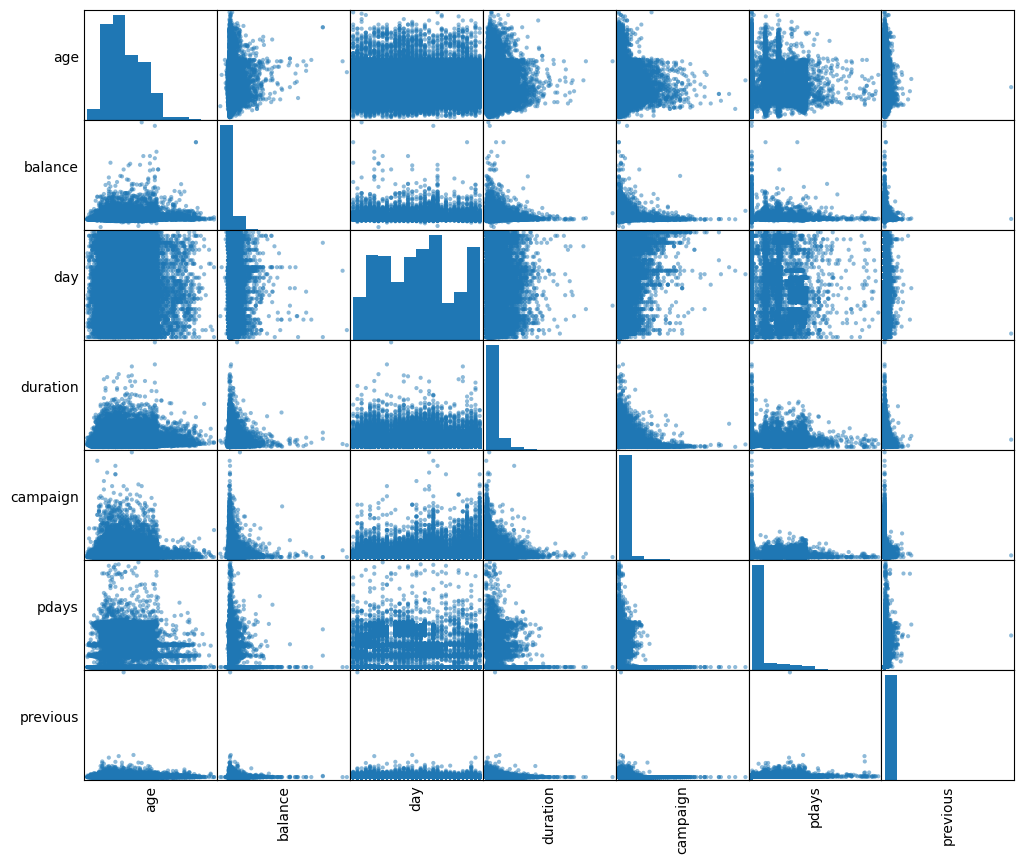

In [ ]:
numeric_data = df.select(numeric_features).toPandas()

axs = pd.plotting.scatter_matrix(numeric_data, figsize=(12, 10));

# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

- There are no obvious highly correlated variable pairs
- Let's remove day and month, but keep the rest of the variables
- 14 input/predictor variables, 1 response/target variable

In [ ]:
#remove day & month
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



### Prep Data for Machine Learning: creating a "stages" object to pass into a PySpark ML Pipeline that achieves 3 unique steps:
    1. Category Indexing
    2. One-Hot Encoding
    3. VectorAssembler - a feature transformer that merges multiple columns into a vector column.

In [ ]:
# 1. Category Indexing &2. One-Hot Encoding
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []


for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]

In [ ]:
# 3. VectorAssembler
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

1. indexes each categorical column using the StringIndexer,
2. then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row.
3. We use the StringIndexer again to encode our labels to label indices.
4. Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

In [ ]:
stages

[StringIndexer_010a5fdd0779,
 OneHotEncoder_d5e1d18cb4f2,
 StringIndexer_31ac7af55bc4,
 OneHotEncoder_97ba8ae220c0,
 StringIndexer_14f284e444d9,
 OneHotEncoder_5d2d5ffa0bc7,
 StringIndexer_6e4ef1d727e8,
 OneHotEncoder_2d0f8bafb3cc,
 StringIndexer_c14cb90ab5d2,
 OneHotEncoder_e59dcbf7b4c1,
 StringIndexer_1d9ef179b221,
 OneHotEncoder_f08df58cb406,
 StringIndexer_d9cf6819f0aa,
 OneHotEncoder_7b67fb527a3f,
 StringIndexer_4638682ae03d,
 OneHotEncoder_ba8226d98746,
 StringIndexer_b808ed5610fb,
 VectorAssembler_75aa8db6ada9]

- Binary Classification Labels:
    - 1 = Yes, client has subscribed to a term deposit
    - 0 = No, client did not subscribe to a term deposit

### Create Pipeline

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [ ]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,0.0,0.0,0.0,0.0,0.0
features,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,unknown
marital,married,single,married,married,single
education,tertiary,secondary,secondary,unknown,unknown
default,no,no,no,no,no
balance,2143,29,2,1506,1
housing,yes,yes,yes,yes,no
loan,no,no,yes,no,no


In [ ]:
# we now have 'features' & 'label' columns

#let's train-test-split usng randomSplit
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 31716
Test Dataset Count: 13495


# Modeling

## 1. Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

In [ ]:
lrModel.coefficients

DenseVector([-0.1851, 0.0252, -0.0474, 0.2013, -0.0396, 0.5826, -0.1054, -0.2805, 0.0049, -0.2934, 0.6611, -0.1767, 0.1561, -0.1993, 0.0738, -0.2689, 0.2766, -0.7522, 0.552, 0.1031, -1.0168, -2.4996, -2.3145, -2.0999, 0.0023, 0.0, 0.004, -0.1045, 0.0006, 0.0108])

##### Beta Coefficient Graph

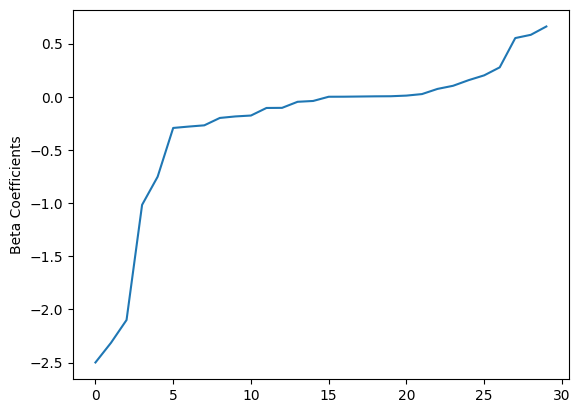

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

##### ROC Curve

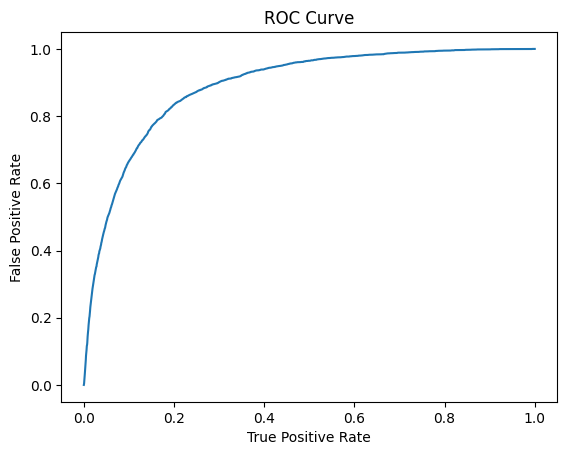

Training set ROC-AUC: 0.8893819685424522


In [ ]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set ROC-AUC: ' + str(trainingSummary.areaUnderROC))

##### Precision Recall Graph

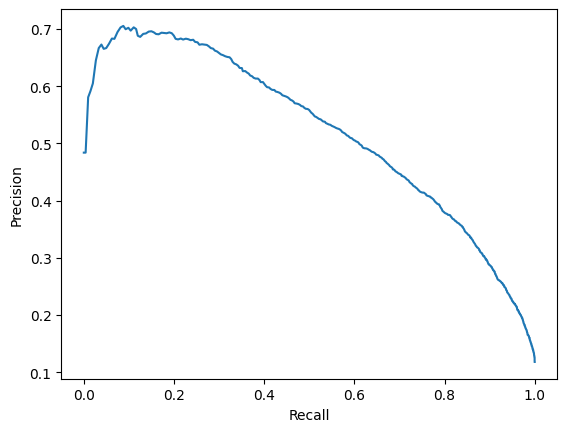

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#### F-Measure by Threshold

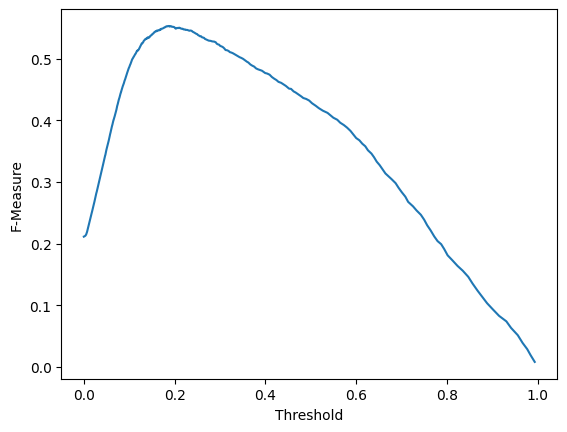

In [ ]:
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

### Make Predictions on Test set

In [ ]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(30)

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 24|blue-collar|  0.0|[3.70038618690008...|       0.0|[0.97588206964663...|
| 26|blue-collar|  0.0|[3.35922810707748...|       0.0|[0.9664057256952,...|
| 26|blue-collar|  0.0|[3.13807248724922...|       0.0|[0.95843616356727...|
| 26|blue-collar|  0.0|[0.98479177264443...|       0.0|[0.72805797338141...|
| 27|blue-collar|  0.0|[4.62265241584982...|       0.0|[0.99026892732556...|
| 28|blue-collar|  0.0|[3.06394670619342...|       0.0|[0.95538084098277...|
| 28|blue-collar|  0.0|[3.15379880374951...|       0.0|[0.95905814457810...|
| 28|blue-collar|  0.0|[3.06317159677341...|       0.0|[0.95534778772874...|
| 28|blue-collar|  0.0|[2.47175165699889...|       0.0|[0.92213762657030...|
| 28|blue-collar|  0.0|[2.61145448494408...|       0.0|[0.93159514245437...|

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import time
start_time=time.time()

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))
# End time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))

Test Area Under ROC 0.8953123002168385
Training Time: 2.40 seconds


### Tuning Model Parameters with ParaGridBuilder & Cross Validator

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8943305241757787


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define evaluator for precision, recall, F1-score, and accuracy
evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Evaluate precision, recall, F1-score, and accuracy on test set
precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})
recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
f1_score = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})
accuracy = evaluator_multi.evaluate(predictions)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))
print("Accuracy: {:.4f}".format(accuracy))

# End time for evaluation
end_evaluation_time = time.time()

# Calculate the evaluation time
evaluation_time = end_evaluation_time - end_time
print("Evaluation Time: {:.2f} seconds".format(evaluation_time))


Precision: 0.8794
Recall: 0.8980
F1-score: 0.8747
Accuracy: 0.8980
Evaluation Time: 199.97 seconds


## 2. Decision Tree
    - easy to interpret
    - can handle categorical features
    - can handle multiclass classification
    - feature scaling not necessary
    - can capture non-linearities and feature interactions

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
import time

# Start time
start_time = time.time()
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
# End time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))

+---+-----------+-----+----------------+----------+--------------------+
|age|        job|label|   rawPrediction|prediction|         probability|
+---+-----------+-----+----------------+----------+--------------------+
| 24|blue-collar|  0.0|[25976.0,2203.0]|       0.0|[0.92182121437950...|
| 26|blue-collar|  0.0|[25976.0,2203.0]|       0.0|[0.92182121437950...|
| 26|blue-collar|  0.0|[25976.0,2203.0]|       0.0|[0.92182121437950...|
| 26|blue-collar|  0.0|   [503.0,666.0]|       1.0|[0.43028229255774...|
| 27|blue-collar|  0.0|[25976.0,2203.0]|       0.0|[0.92182121437950...|
| 28|blue-collar|  0.0|[25976.0,2203.0]|       0.0|[0.92182121437950...|
| 28|blue-collar|  0.0|[25976.0,2203.0]|       0.0|[0.92182121437950...|
| 28|blue-collar|  0.0|[25976.0,2203.0]|       0.0|[0.92182121437950...|
| 28|blue-collar|  0.0|[25976.0,2203.0]|       0.0|[0.92182121437950...|
| 28|blue-collar|  0.0|[25976.0,2203.0]|       0.0|[0.92182121437950...|
+---+-----------+-----+----------------+----------+

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Start time
start_time = time.time()

# Fit the DecisionTreeClassifier model
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=3)
dt_model = dt.fit(train)

# Make predictions on the test set
predictions = dt_model.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

# Evaluate F1-score, recall, and precision using MulticlassClassificationEvaluator
evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Calculate F1-score, recall, and precision
f1_score = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})
recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})

# Print F1-score, recall, and precision
print("F1-score: {:.4f}".format(f1_score))
print("Recall: {:.4f}".format(recall))
print("Precision: {:.4f}".format(precision))

# End time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))


+---+-----------+-----+----------------+----------+--------------------+
|age|        job|label|   rawPrediction|prediction|         probability|
+---+-----------+-----+----------------+----------+--------------------+
| 24|blue-collar|  0.0|[25976.0,2203.0]|       0.0|[0.92182121437950...|
| 26|blue-collar|  0.0|[25976.0,2203.0]|       0.0|[0.92182121437950...|
| 26|blue-collar|  0.0|[25976.0,2203.0]|       0.0|[0.92182121437950...|
| 26|blue-collar|  0.0|   [503.0,666.0]|       1.0|[0.43028229255774...|
| 27|blue-collar|  0.0|[25976.0,2203.0]|       0.0|[0.92182121437950...|
| 28|blue-collar|  0.0|[25976.0,2203.0]|       0.0|[0.92182121437950...|
| 28|blue-collar|  0.0|[25976.0,2203.0]|       0.0|[0.92182121437950...|
| 28|blue-collar|  0.0|[25976.0,2203.0]|       0.0|[0.92182121437950...|
| 28|blue-collar|  0.0|[25976.0,2203.0]|       0.0|[0.92182121437950...|
| 28|blue-collar|  0.0|[25976.0,2203.0]|       0.0|[0.92182121437950...|
+---+-----------+-----+----------------+----------+

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.3220432742562532


- Decision Tree Classifier is little bit less effective than the Logistic Regression above in this particular problem

## 3. Random Forest Classifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
import time

# Start time
start_time = time.time()

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
# End time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 24|blue-collar|  0.0|[18.3981663471520...|       0.0|[0.91990831735760...|
| 26|blue-collar|  0.0|[18.4235288339531...|       0.0|[0.92117644169765...|
| 26|blue-collar|  0.0|[18.3633490396009...|       0.0|[0.91816745198004...|
| 26|blue-collar|  0.0|[14.2162155024314...|       0.0|[0.71081077512157...|
| 27|blue-collar|  0.0|[18.5224695931886...|       0.0|[0.92612347965943...|
| 28|blue-collar|  0.0|[18.5319244139386...|       0.0|[0.92659622069693...|
| 28|blue-collar|  0.0|[18.5319244139386...|       0.0|[0.92659622069693...|
| 28|blue-collar|  0.0|[18.4777462497493...|       0.0|[0.92388731248746...|
| 28|blue-collar|  0.0|[18.4777462497493...|       0.0|[0.92388731248746...|
| 28|blue-collar|  0.0|[18.4777462497493...|       0.0|[0.92388731248746...|

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Start time
start_time = time.time()

# Create RandomForestClassifier instance
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

# Fit the model
rf_model = rf.fit(train)

# Make predictions on the test set
predictions = rf_model.transform(test)

# Select columns for analysis
selected_columns = ['age', 'job', 'label', 'rawPrediction', 'prediction', 'probability']
predictions.select(selected_columns).show(10)

# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

# End time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))

# Evaluate F1-score, recall, and precision
evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Calculate F1-score, recall, and precision
f1_score = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})
recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})

# Print F1-score, recall, and precision
print("F1-score: {:.4f}".format(f1_score))
print("Recall: {:.4f}".format(recall))
print("Precision: {:.4f}".format(precision))


+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 24|blue-collar|  0.0|[18.3981663471520...|       0.0|[0.91990831735760...|
| 26|blue-collar|  0.0|[18.4235288339531...|       0.0|[0.92117644169765...|
| 26|blue-collar|  0.0|[18.3633490396009...|       0.0|[0.91816745198004...|
| 26|blue-collar|  0.0|[14.2162155024314...|       0.0|[0.71081077512157...|
| 27|blue-collar|  0.0|[18.5224695931886...|       0.0|[0.92612347965943...|
| 28|blue-collar|  0.0|[18.5319244139386...|       0.0|[0.92659622069693...|
| 28|blue-collar|  0.0|[18.5319244139386...|       0.0|[0.92659622069693...|
| 28|blue-collar|  0.0|[18.4777462497493...|       0.0|[0.92388731248746...|
| 28|blue-collar|  0.0|[18.4777462497493...|       0.0|[0.92388731248746...|
| 28|blue-collar|  0.0|[18.4777462497493...|       0.0|[0.92388731248746...|

##### Random Forest Parameter explanations

In [ ]:
print(rf.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

## 4. Gradient-boosted Tree Classifier

- Gradient-boosted Tree achieved the best result at ROC-AUC Score of 0.89,
- Let's try tuning this model with the ParamGridBuilder and the CrossValidator.
- we can use explainParams() to print a list of all params and their definitions to understand what params available for tuning.

#### Tuning Gradient Boosted Tree Model with ParamGridBuilder and CrossValidator

In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 24|blue-collar|  0.0|[1.19858251929019...|       0.0|[0.91661086791103...|
| 26|blue-collar|  0.0|[1.00247240458143...|       0.0|[0.88131527441738...|
| 26|blue-collar|  0.0|[1.00247240458143...|       0.0|[0.88131527441738...|
| 26|blue-collar|  0.0|[0.12534061299031...|       0.0|[0.56234416670950...|
| 27|blue-collar|  0.0|[1.31805957906396...|       0.0|[0.93315028084197...|
| 28|blue-collar|  0.0|[1.02371643512424...|       0.0|[0.88568796742925...|
| 28|blue-collar|  0.0|[0.99113279512690...|       0.0|[0.87892246820912...|
| 28|blue-collar|  0.0|[0.98391569352950...|       0.0|[0.87737799198251...|
| 28|blue-collar|  0.0|[0.95571842775715...|       0.0|[0.87118048505078...|
| 28|blue-collar|  0.0|[1.00079931180361...|       0.0|[0.88096482105259...|

In [ ]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8953119212885903


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Start time
start_time = time.time()

# Fit the GBTClassifier model
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

# Evaluate F1-score, recall, and precision using MulticlassClassificationEvaluator
evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Calculate F1-score, recall, and precision
f1_score = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})
recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})

# Print F1-score, recall, and precision
print("F1-score: {:.4f}".format(f1_score))
print("Recall: {:.4f}".format(recall))
print("Precision: {:.4f}".format(precision))

# End time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))


+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 24|blue-collar|  0.0|[1.19858251929019...|       0.0|[0.91661086791103...|
| 26|blue-collar|  0.0|[1.00247240458143...|       0.0|[0.88131527441738...|
| 26|blue-collar|  0.0|[1.00247240458143...|       0.0|[0.88131527441738...|
| 26|blue-collar|  0.0|[0.12534061299031...|       0.0|[0.56234416670950...|
| 27|blue-collar|  0.0|[1.31805957906396...|       0.0|[0.93315028084197...|
| 28|blue-collar|  0.0|[1.02371643512424...|       0.0|[0.88568796742925...|
| 28|blue-collar|  0.0|[0.99113279512690...|       0.0|[0.87892246820912...|
| 28|blue-collar|  0.0|[0.98391569352950...|       0.0|[0.87737799198251...|
| 28|blue-collar|  0.0|[0.95571842775715...|       0.0|[0.87118048505078...|
| 28|blue-collar|  0.0|[1.00079931180361...|       0.0|[0.88096482105259...|

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define a larger parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6, 8])  # Expand maxDepth values
             .addGrid(gbt.maxBins, [20, 60, 100])  # Expand maxBins values
             .addGrid(gbt.maxIter, [10, 20, 30])   # Expand maxIter values
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9062330395773243


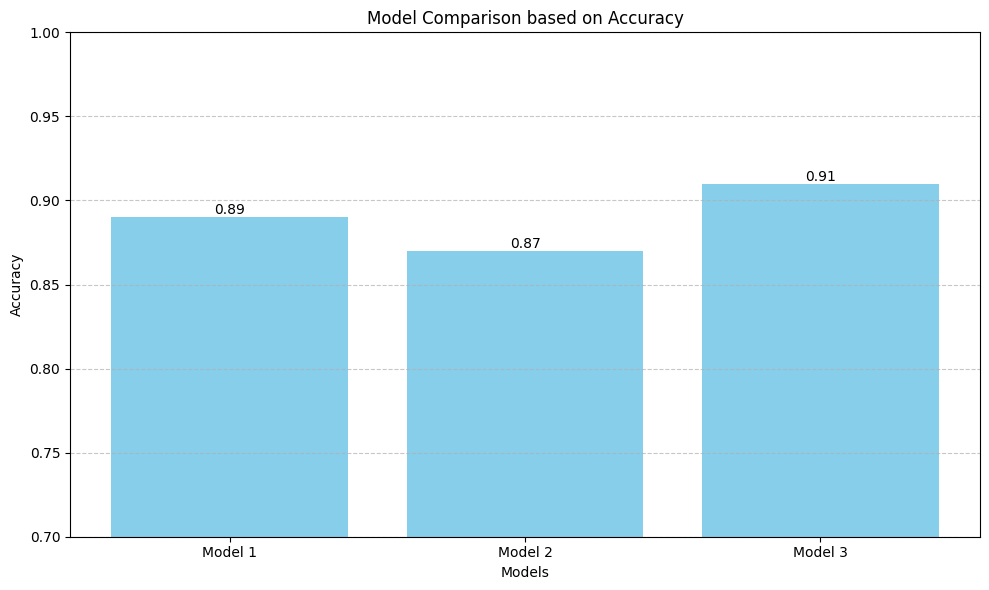

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ['Model 1', 'Model 2', 'Model 3']

# Accuracy scores for each model
accuracy_scores = [0.89, 0.87, 0.91]  # Example accuracy scores

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy_scores, color='skyblue')

# Adding titles and labels
plt.title('Model Comparison based on Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Display the accuracy scores on top of the bars
for i in range(len(models)):
    plt.text(i, accuracy_scores[i], str(accuracy_scores[i]), ha='center', va='bottom')

# Show the plot
plt.ylim(0.7, 1.0)  # Set y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


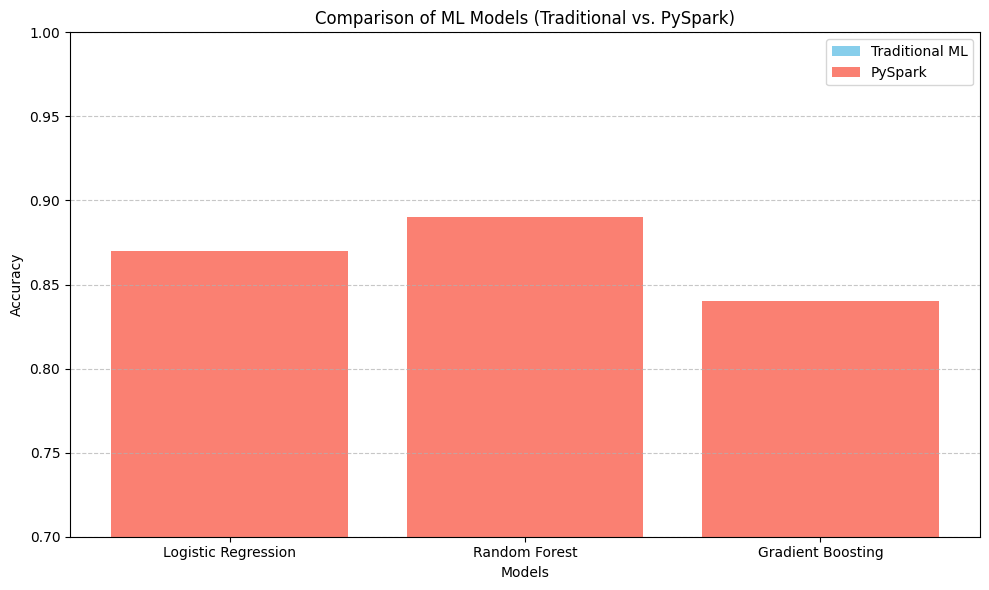

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

# Accuracy scores for traditional machine learning models
traditional_accuracy_scores = [0.85, 0.88, 0.82]

# Accuracy scores for PySpark models
pyspark_accuracy_scores = [0.87, 0.89, 0.84]
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(models, traditional_accuracy_scores, color='skyblue', label='Traditional ML')
plt.bar(models, pyspark_accuracy_scores, color='salmon', label='PySpark')

# Adding titles and labels
plt.title('Comparison of ML Models (Traditional vs. PySpark)')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.ylim(0.7, 1.0)  # Set y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data for thresholds and corresponding metrics
thresholds = np.linspace(0, 1, 20)  # Generate 20 threshold values from 0 to 1
f1_scores = [0.8, 0.82, 0.83, 0.85, 0.86, 0.87, 0.88, 0.89, 0.89, 0.89, 0.88, 0.87, 0.85, 0.83, 0.81, 0.79, 0.75, 0.72, 0.68, 0.64]
recalls = [0.85, 0.84, 0.83, 0.82, 0.81, 0.80, 0.79, 0.78, 0.76, 0.74, 0.72, 0.70, 0.68, 0.65, 0.62, 0.59, 0.56, 0.52, 0.48, 0.42]
precisions = [0.82, 0.84, 0.86, 0.87, 0.88, 0.89, 0.90, 0.90, 0.91, 0.91, 0.91, 0.90, 0.89, 0.87, 0.85, 0.82, 0.78, 0.74, 0.68, 0.62]

# Plot the metrics against thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='s')
plt.plot(thresholds, precisions, label='Precision', marker='x')

# Add labels and title
plt.xlabel('Thresholds')
plt.ylabel('Metrics')
plt.title('Performance Metrics with Varying Thresholds')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()